# Imports

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import gzip
import scipy.sparse as sparse

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 12,

    # Axes
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 2,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

# Auxiliary functions

In [164]:
def get_root_models(path_models:pathlib.Path):
    dfs = []
    for entry in path_models.iterdir():
        # check if it is a root model
        if entry.name.startswith("htm"):
            
            # Path to the root model
            path = entry

            # Thr and exp_tpc do not apply for the root model
            thr = -1
            exp_tpc = -1

            # Experiment iteration
            iter_ = -1
            
            # tr_topics
            tr_topics = int(path.name.split("_")[1])

            # Size of the topics
            alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()
            alphas = list(map(lambda x: x * 100, alphas))

            # Coherences (CV and NPMI)
            cohrs_cv = np.load(path.joinpath('TMmodel/c_v_ref_coherence.npy')).tolist()
            cohrs_npmi = np.load(path.joinpath('TMmodel/c_npmi_ref_coherence.npy')).tolist()

            # Topics' entropies
            entropies = np.load(path.joinpath('TMmodel/topic_entropy.npy')).tolist()

            # TD
            td = np.load(path.joinpath('TMmodel/td.npy'))

            # IRBO 
            rbo = np.load(path.joinpath('TMmodel/rbo.npy'))
            
            # tpc_Desc
            with path.joinpath('TMmodel/tpc_descriptions.txt').open('r', encoding='utf8') as fin:
                tpc_descriptions = [el.strip() for el in fin.readlines()]

            # Ids of the topics
            tpc_ids = np.arange(0,len(alphas),1)

            # Corpus size
            if path.joinpath('corpus.txt').is_file():
                corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                    path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                size = len(corpus)
            elif path.joinpath('corpus.parquet').is_dir():
                dfc = pd.read_parquet(path.joinpath('corpus.parquet'))
                size = len(dfc)

            # Create dataframe for the root model
            root_tpc_df = pd.DataFrame(
                {'iter': [iter_] * len(alphas),
                 'path': [path] * len(alphas),
                 'cohrs_cv': cohrs_cv,
                 'cohrs_npmi': cohrs_npmi,
                 'entropies': entropies,
                 'td': [td] * len(alphas),
                 'rbo': [rbo] * len(alphas),
                 'alphas': alphas,
                 'tpc_ids': tpc_ids,
                 'thr': [thr] * len(alphas),
                 'exp_tpc': [exp_tpc] * len(alphas),
                 'tr_tpcs': [tr_topics] * len(alphas),
                 'tpc_descriptions': tpc_descriptions
                })

            # Append to the list of dataframes to concatenate them
            dfs.append(root_tpc_df)
    df = pd.concat(dfs)
    df = df.sort_values(by=['iter'])
    return df


def get_submodules(df:pd.DataFrame):
    # Iter over each root model (according to its corresponding iteration, iter)
    concats = [df]
    not_finished = []
    path_root = df.iloc[0].path
    for entry in path_root.iterdir():
        if entry.joinpath('TMmodel/topic_coherence.npy').is_file() and not entry.as_posix().endswith("old"):
            try:
                if "ws" in entry.as_posix():
                    thr = 0
                    size = 0
                else:
                    thr = float(entry.as_posix().split("thr_")[1].split("_")[0])

                    if entry.joinpath('corpus.txt').is_file():
                        corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                                    entry.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                        size = len(corpus)
                    elif entry.joinpath('corpus.parquet').is_dir():
                        dfc = pd.read_parquet(entry.joinpath('corpus.parquet'))
                        size = len(dfc)
                    size = size * 100 / root_size
                    
                # get iter
                iter_ = int(entry.name.split("_iter_")[1].split("_")[0])
                
                # get topic from which the submodel is generated
                exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])

                # Size of the topics
                alphas = np.load(entry.joinpath('TMmodel/alphas.npy')).tolist()
                alphas = list(map(lambda x: x * 100, alphas))

                # Alphas submodel is the mean of the cohr of its topics
                alpha = np.mean(alphas)

                # Coherences (CV and NPMI)
                cohrs_cv = np.load(entry.joinpath('TMmodel/c_v_ref_coherence.npy')).tolist()
                cohrs_npmi = np.load(entry.joinpath('TMmodel/c_npmi_ref_coherence.npy'), allow_pickle=True).tolist()
                if cohrs_npmi is None:
                    cohrs_npmi = [0]*len(cohrs_cv)

                # cohr submodel is the mean of the cohr of its topics
                cohr_cv = np.mean(cohrs_cv)
                cohr_npmi = np.mean(cohrs_npmi)

                # TD
                td = np.load(entry.joinpath('TMmodel/td.npy'))

                # IRBO 
                rbo = np.load(entry.joinpath('TMmodel/rbo.npy'))

                # Topics' entropies
                entropy = np.mean(np.load(entry.joinpath('TMmodel/topic_entropy.npy')).tolist())

                tr_tpcs = int(entry.as_posix().split("train_with_")[1].split("_")[0])

                # tpc_Desc
                with entry.joinpath('TMmodel/tpc_descriptions.txt').open('r', encoding='utf8') as fin:
                    tpc_descriptions = [el.strip() for el in fin.readlines()]
                
                # add entry of submodel to dataframe
                root_tpc_df = pd.DataFrame(
                {'iter': [iter_],
                 'path': [entry],
                 'cohrs_cv': [cohr_cv],
                 'cohrs_npmi': [cohr_npmi],
                 'entropies': [entropy],
                 'alphas': [alpha],
                 'td': [td],
                 'rbo': [rbo],
                 'tpc_ids': [exp_tpc],
                 'thr': [thr],
                 'exp_tpc': [exp_tpc],
                 'size': [size],
                 'tr_tpcs': [tr_tpcs],
                 'tpc_descriptions': [tpc_descriptions]
                })
                                
                concats.append(root_tpc_df)

            except:
                not_finished.append(entry)

        else:
            not_finished.append(entry)
    df = pd.concat(concats)
    
    return df

def get_df_all_models(path_models:pathlib.Path):
    df_root, root_size = get_root_models(path_models)
    df_all = get_submodules(df_root)
    return df_all, root_size

In [136]:
def get_graphs_root_model(df,n_tpcs):
    
    # Get all root models
    df_root = df[df.thr==-1]
    # Get root model trained with n_tpcs
    df_root = df_root[df_root.tr_tpcs==n_tpcs]
    # Get root size
    if df_root.iloc[0].path.joinpath('corpus.txt').is_file():
        corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                    df_root.iloc[0].path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
        root_size = len(corpus)
    elif df_root.iloc[0].path.joinpath('corpus.parquet').is_dir() or df_root.iloc[0].path.joinpath('corpus.parquet').is_file():
        dfc = pd.read_parquet(df_root.iloc[0].path.joinpath('corpus.parquet'))
        root_size = len(dfc)    
    
    # Calculate average cohrs and entropy
    df_root_plot = df_root.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'alphas', 'td', 'rbo']].mean()
    df_root_plot = df_root_plot.rename(columns={'cohrs_cv': 'cohrs_cv_mean',
                                                'cohrs_npmi': 'cohrs_npmi_mean',
                                                'entropies': 'entropies_mean',
                                                'alphas': 'alphas_mean',
                                                })
    df_root_plot['tpc_ids'] = np.arange(0,len(df_root),1)
    df_root_plot['td'] =  [df_root['td'].values[0].tolist()]*len(df_root)
    df_root_plot['rbo'] =  [df_root['rbo'].values[0].tolist()]*len(df_root)
    df_root_plot['tpc_descriptions'] = df_root['tpc_descriptions'].values.tolist()
    
    # Plot figure
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18.5, 2))
    y_repr = ['cohrs_cv', 'cohrs_npmi', 'entropies']
    y_labels = ['$C_{V}$', '$C_{NPMI}$', '$TE$']
    colors = ["#35A29F", "#2D6187",  "#387838"] 
    labels_all = []
    handles_all = []
    for yrepr, ylabel, color, ax in zip(y_repr, y_labels, colors, axs.flat):

        df_root_plot.plot.bar(
            ax=ax,
            y=yrepr + "_mean",
            #yerr = yrepr + "_var",
            label=ylabel, use_index=True, stacked=True,
            color = color,
            capsize=4)
        ax2 = df_root_plot.plot(
                ax=ax, 
                y='alphas_mean', kind = 'line', label='Size', color="#A9294F", use_index=True, secondary_y=True)

        ax.grid(True)
        ax.set_xlabel('Topic ID')
        ax2.grid(True)
        ax.get_legend().remove()
        handles, labels = ax.get_legend_handles_labels()
        labels_all += labels
        handles_all += handles

    handles2, labels2 = ax2.get_legend_handles_labels()

    fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=4, bbox_to_anchor=(0.513, 1.04),
               frameon=True, shadow=False)

    save_fig = f"{folder_save}/root_model_{corpus_name}_{n_tpcs}_tpcs_{model_type}.png"
    fig.savefig(save_fig, dpi='figure', bbox_inches='tight')
    
    return df_root_plot, df_root, root_size

In [198]:
def get_ws_graphs(df_sub, df_root):
    
    # get ws submodels
    df = df_sub[df_sub.thr==0]
    
    def my_agg(x):
        names = {
            'cohrs_cv_mean': x['cohrs_cv'].mean(),
            'cohrs_npmi_mean': x['cohrs_npmi'].mean(),
            'entropies_mean':x['entropies'].mean(),
            'alphas_mean':x['alphas'].mean(),
            'td_mean':x['td'].mean(),
            'rbo_mean':x['rbo'].mean(),
            'cohrs_cv_var':x['cohrs_cv'].std(),
            'cohrs_npmi_var':x['cohrs_npmi'].std(),
            'entropies_var':x['entropies'].std(),
            'alphas_var':x['alphas'].std(),
            'td_var':x['td'].std(),
            'rbo_var':x['rbo'].std()}

        return pd.Series(names, index=['cohrs_cv_mean', 'cohrs_npmi_mean','entropies_mean', 'alphas_mean', 'td_mean', 'rbo_mean',
                                       'cohrs_cv_var', 'cohrs_npmi_var','entropies_var', 'alphas_var', 'td_var', 'rbo_var'])
    
    df_plot = df.groupby(['exp_tpc', 'tr_tpcs'], as_index=False).apply(my_agg)
    
    my_xticks = df_plot.tr_tpcs.unique().tolist()
    
    metrics = ['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']
    nr_cols = len(df_plot.exp_tpc.unique())
    for metric in metrics:
        metric_y = metric + '_mean'
        metric_y_root = metric + '_mean' if metric not in ['td', 'rbo'] else metric
        metric_y_err = metric + '_var'
        fig, axs = plt.subplots(nrows=1, ncols=nr_cols, figsize = (20.5, 2), sharex=True, sharey=True)
        for tpc, ax in zip(sorted(df_plot.exp_tpc.unique()), axs.flat):
            aux = df_plot[df_plot.exp_tpc == tpc]
            aux.plot(
                ax=ax,
                x='tr_tpcs',
                y=metric_y,
                yerr=metric_y_err,
                color='green',
                ecolor='black',
                linewidth=2, 
                capsize=2,
                rot=0,
                kind='line'  
            )
            y_ = df_root[df_root.tpc_ids==tpc][metric_y_root].values[0]
            if isinstance(y_, np.ndarray):
                y_ = y_.tolist()[0]
            ax.axhline(y=y_, xmin=-1, xmax=len(my_xticks), label='Father model')
            ax.get_legend().remove()
            ax.set_xticks(my_xticks)
            ax.set_xlabel('Tr tpcs')
            ax.set_ylabel(metric)
            ax.set_title(f'Submodels from topic {tpc}')
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.51, 1.18),
                      frameon=True, shadow=False)
            
    return df

# CORDIS

## Mallet models

In [232]:
path_models = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_variability_models")
folder_save = "images/cordis/mallet"
corpus_name = "Cordis"
model_type = "mallet"

In [ ]:
df = get_root_models(path_models)

### 6 topics root model

,cohrs_cv_mean,cohrs_npmi_mean,entropies_mean,alphas_mean,tpc_ids,td,rbo,tpc_descriptions
tpc_ids,,,,,,,,
0,0.477,-0.023,0.825,27.992,0,0.889,0.964,"cellular, genetic, cancer, disease, protein, molecule, ribonucleic_acid, deoxyribonucleic_acid, genomic, plant, vivo, therapeutic, tumor, metabolic, tissue"
1,0.587,0.058,0.781,19.421,1,0.889,0.964,"quantum, molecule, electric, catalysis, optic, photonic, polymer, atom, graphene, semiconductor, electron, nanoscale, nanostructure, laser, magnetic"
2,0.762,0.125,0.766,14.497,2,0.889,0.964,"energy, water, carbon_dioxide, aircraft, plant, emission, waste, electric, farming, battery, vehicle, fuel, operation, food, electricity"
3,0.761,0.088,0.739,13.843,3,0.889,0.964,"language, cognitive, robotic, child, semantic, linguistic, video, speech, heritage, mobile, automatic, scalability, interactive, literature, voice"
4,0.788,0.125,0.755,12.143,4,0.889,0.964,"patient, clinical, brain, therapeutic, disease, cancer, neuronal, drug, healthcare, health, biomarker, tissue, tumor, treatment, clinical_trial"
5,0.661,0.056,0.783,12.104,5,0.889,0.964,"climate, climate_change, water, soil, specie, forest, biodiversity, ocean, plant, marine, galaxy, earth, carbon, land, sea"


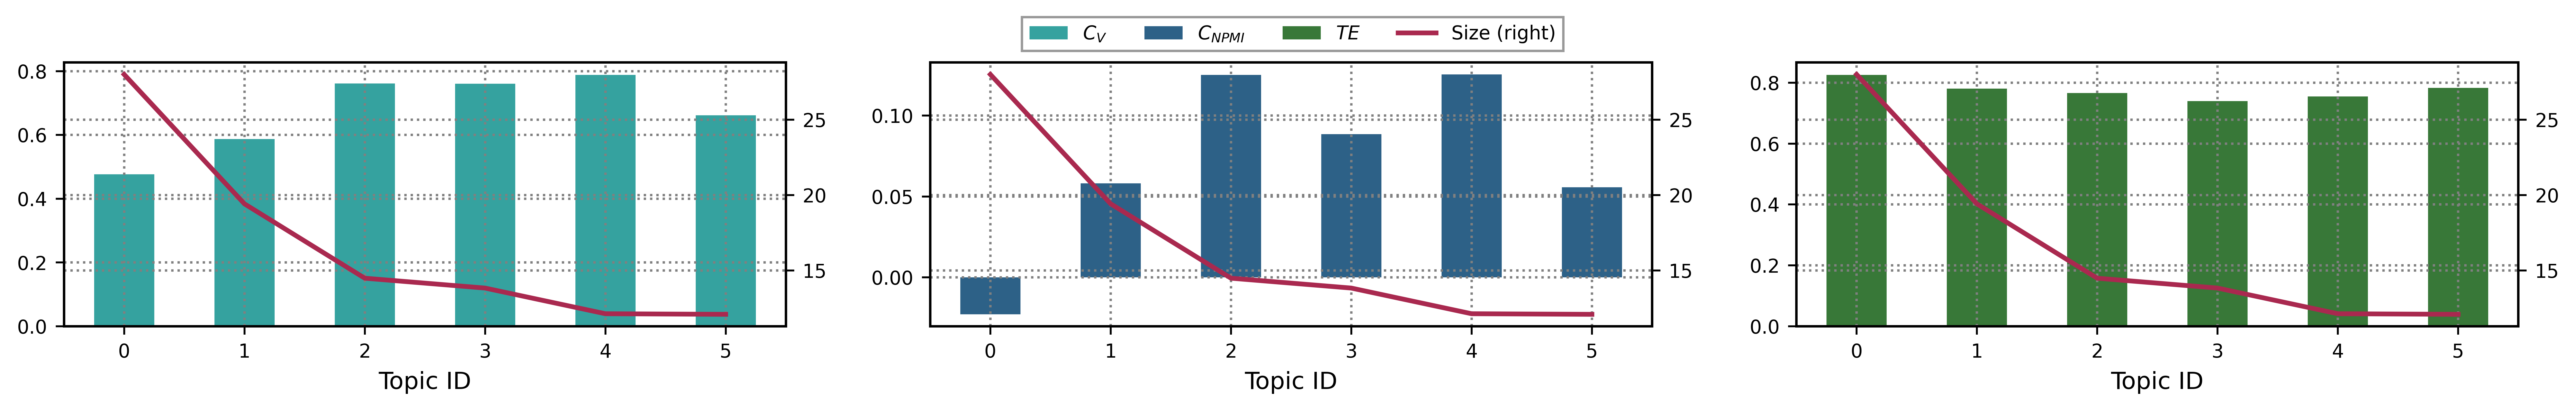

In [138]:
df6, df6_root, root_size6 = get_graphs_root_model(df,6)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df6)

#### Submodels

In [201]:
df6_sub = get_submodules(df6_root)

##### HTM-WS

In [224]:
df6_ws = get_ws_graphs(df6_sub, df6)

In [231]:
tpc = 0
filtered_df = df6_ws[(df6_ws['iter'] == 0) & (df6_ws['exp_tpc'] == tpc) & (df6_ws['tr_tpcs'] == 10)].explode('tpc_descriptions')
filtered_df['id'] = np.arange(len(filtered_df))

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth', None):
    display(filtered_df[['id', 'tpc_descriptions']])

,id,tpc_descriptions
0,0,"consultation, open_access, nuclear, health, regions, policy_dialogue, delivery, harmonise, secretariat, funding_agency, funder, joint_programming, stakeholder_engagement, cso, drive"
0,1,"tourism, estonia, doctoral_programme, age, profession, universities, presentation, curriculum, phd_programme, public_engagement, greece, festival, edition, cofund, bulgaria"
0,2,"indigenous, philosophy, anthropology, peace, ethnography, legitimacy, elite, military, electoral, election, protest, populism, feminist, equality, politics"
0,3,"computation, machine_learning, semantic, language, deep_learning, automatic, logic, graph, verification, machine_translation, workflow, proof, ontology, computer_science, reasoning"
0,4,"computation, wireless, hpc, heterogeneous, scalability, hardware, mobile, cps, edge, exascale, processor, radio, node, cloud_computing, layer"
0,5,"firm, child, family, macroeconomic, poverty, behaviour, demographic, longitudinal, fertility, shock, behavioural, parent, implication, heterogeneity, tax"
0,6,"video, mobile, virtual_reality, image, camera, tv, smartphone, ar, payment, immersive, mobile_device, visual, display, interactive, travel"
0,7,"robotic, language, cognitive, linguistic, speech, cognition, computation, emotion, child, visual, interaction, manipulation, semantic, infant, robotics"
0,8,"archaeology, heritage, literature, ancient, medieval, empire, roman, islamic, colonial, language, imperial, artistic, writing, religion, corpus"
0,9,"blockchain, critical_infrastructure, cryptographic, vulnerability, cryptography, responder, biometric, cyber_security, criminal, cyber, surveillance, protect, security_privacy, incident, authentication"


### 8 topics root model

,cohrs_cv_mean,cohrs_npmi_mean,entropies_mean,alphas_mean,tpc_ids,td,rbo,tpc_descriptions
tpc_ids,,,,,,,,
0,0.491,0.019,0.817,18.894,0,0.9,0.98,"language, child, linguistic, cognitive, archaeology, heritage, emotion, literature, medieval, visual, health, corpus, semantic, speech, philosophy"
1,0.482,0.007,0.787,15.836,1,0.9,0.98,"molecule, catalysis, chemical, nanoparticle, polymer, protein, organic, electric, metal, cellular, nanostructure, membrane, graphene, fabrication, nanoscale"
2,0.734,0.106,0.760,12.698,2,0.9,0.98,"quantum, optic, photonic, laser, galaxy, energy, particle, electron, atom, spin, detector, photon, nonlinear, magnetic_field, magnetic"
3,0.775,0.097,0.734,12.390,3,0.9,0.98,"plant, climate, water, climate_change, specie, soil, farming, biodiversity, genetic, food, agriculture, crop, ocean, ecological, marine"
4,0.827,0.141,0.739,10.286,4,0.9,0.98,"patient, clinical, therapeutic, cancer, disease, drug, tumor, healthcare, biomarker, treatment, clinical_trial, health, vaccine, tissue, cellular"
5,0.714,0.120,0.756,10.218,5,0.9,0.98,"cellular, genetic, protein, neuronal, brain, deoxyribonucleic_acid, molecule, cancer, genomic, ribonucleic_acid, disease, vivo, mouse, metabolic, t_cell"
6,0.725,0.090,0.761,10.196,6,0.9,0.98,"energy, water, carbon_dioxide, waste, aircraft, emission, plant, energy_efficiency, heat, fuel, solar, electric, battery, renewable_energy, electricity"
7,0.644,0.084,0.753,9.483,7,0.9,0.98,"robotic, wireless, automatic, sensor, operation, transport, vehicle, hardware, scalability, artificial_intelligence, satellite, hpc, traffic, airport, gnss"


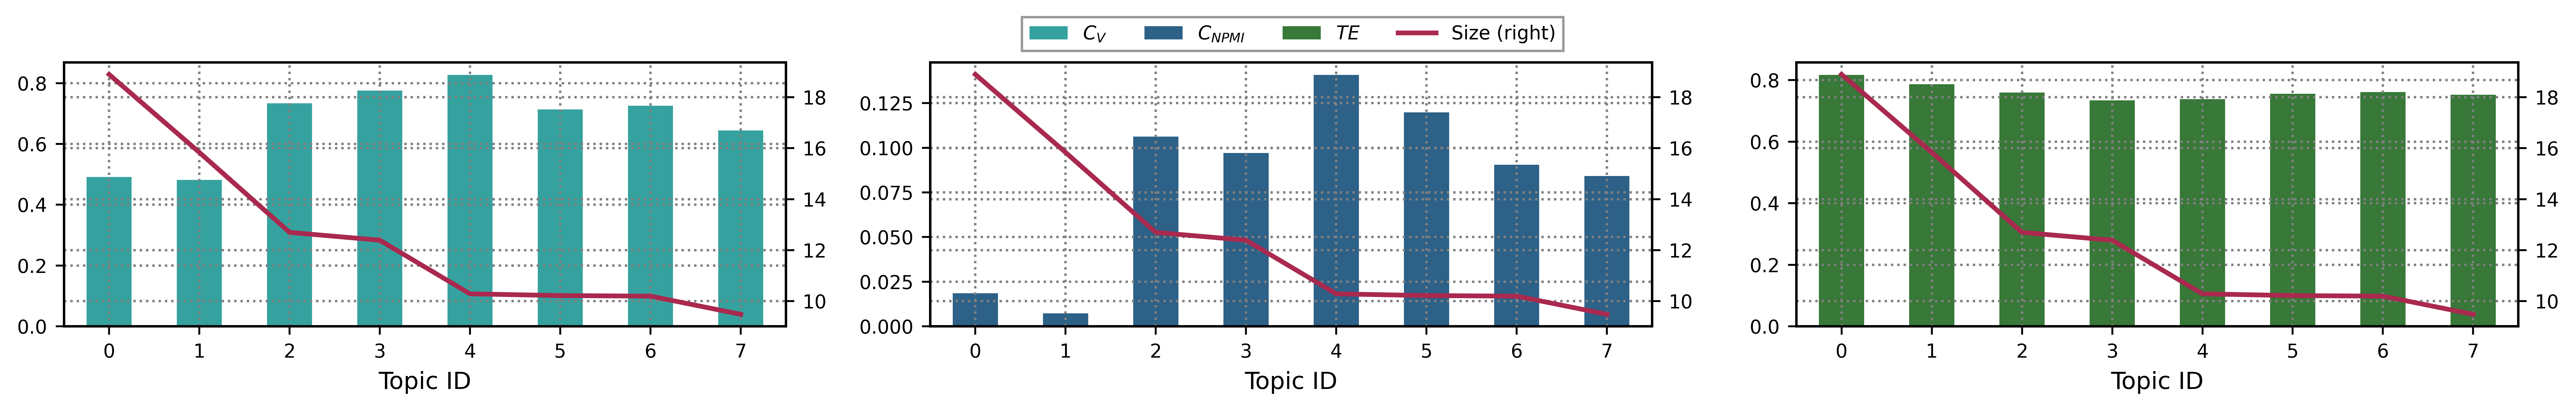

In [230]:
df8, df8_root, root_size8 = get_graphs_root_model(df,8)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df8)

#### Submodels

In [ ]:
df8_sub = get_submodules(df8_root)

##### HTM-WS

In [ ]:
df8_ws = get_ws_graphs(df8_sub, df8)

In [ ]:
tpc = 5
filtered_df = df6_ws[(df6_ws['iter'] == 0) & (df6_ws['exp_tpc'] == tpc) & (df6_ws['tr_tpcs'] == 10)].explode('tpc_descriptions')
filtered_df['id'] = np.arange(len(filtered_df))

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth', None):
    display(filtered_df[['id', 'tpc_descriptions']])

### 10 topics root model

,cohrs_cv_mean,cohrs_npmi_mean,entropies_mean,alphas_mean,tpc_ids,td,rbo,tpc_descriptions
tpc_ids,,,,,,,,
0,0.432,-0.023,0.818,18.322,0,0.84,0.966,"language, child, heritage, archaeology, health, literature, firm, medieval, linguistic, personal, age, ancient, philosophy, book, translation"
1,0.578,0.052,0.782,16.719,1,0.84,0.966,"energy, robotic, aircraft, vehicle, electric, sensor, energy_efficiency, operation, wireless, mobile, inspection, automatic, transport, engine, wind"
2,0.835,0.113,0.724,10.889,2,0.84,0.966,"cellular, protein, genetic, deoxyribonucleic_acid, cancer, disease, molecule, ribonucleic_acid, vivo, t_cell, genomic, therapeutic, tumor, tissue, stem_cell"
3,0.738,0.106,0.754,10.306,3,0.84,0.966,"catalysis, water, carbon_dioxide, energy, chemical, waste, metal, plant, hydrogen, carbon, solar, emission, coating, polymer, fuel"
4,0.784,0.141,0.747,9.858,4,0.84,0.966,"quantum, optic, electric, molecule, photonic, laser, electron, magnetic, atom, semiconductor, nanoscale, fabrication, nanostructure, graphene, imaging"
5,0.820,0.145,0.733,9.301,5,0.84,0.966,"patient, clinical, therapeutic, disease, cancer, healthcare, drug, tumor, health, treatment, biomarker, tissue, vaccine, clinical_trial, infection"
6,0.694,0.105,0.738,7.765,6,0.84,0.966,"plant, genetic, food, agriculture, farming, specie, soil, water, crop, genomic, animal, biodiversity, forest, climate_change, population"
7,0.557,0.028,0.749,6.415,7,0.84,0.966,"quantum, computation, language, conjecture, geometric, hpc, topology, graph, semantic, dynamical, nonlinear, geometry, machine_learning, mathematic, equation"
8,0.518,-0.004,0.751,5.651,8,0.84,0.966,"climate, earth, ocean, galaxy, particle, climate_change, water, atmospheric, universe, emission, carbon, solar, observation, seismic, arctic"


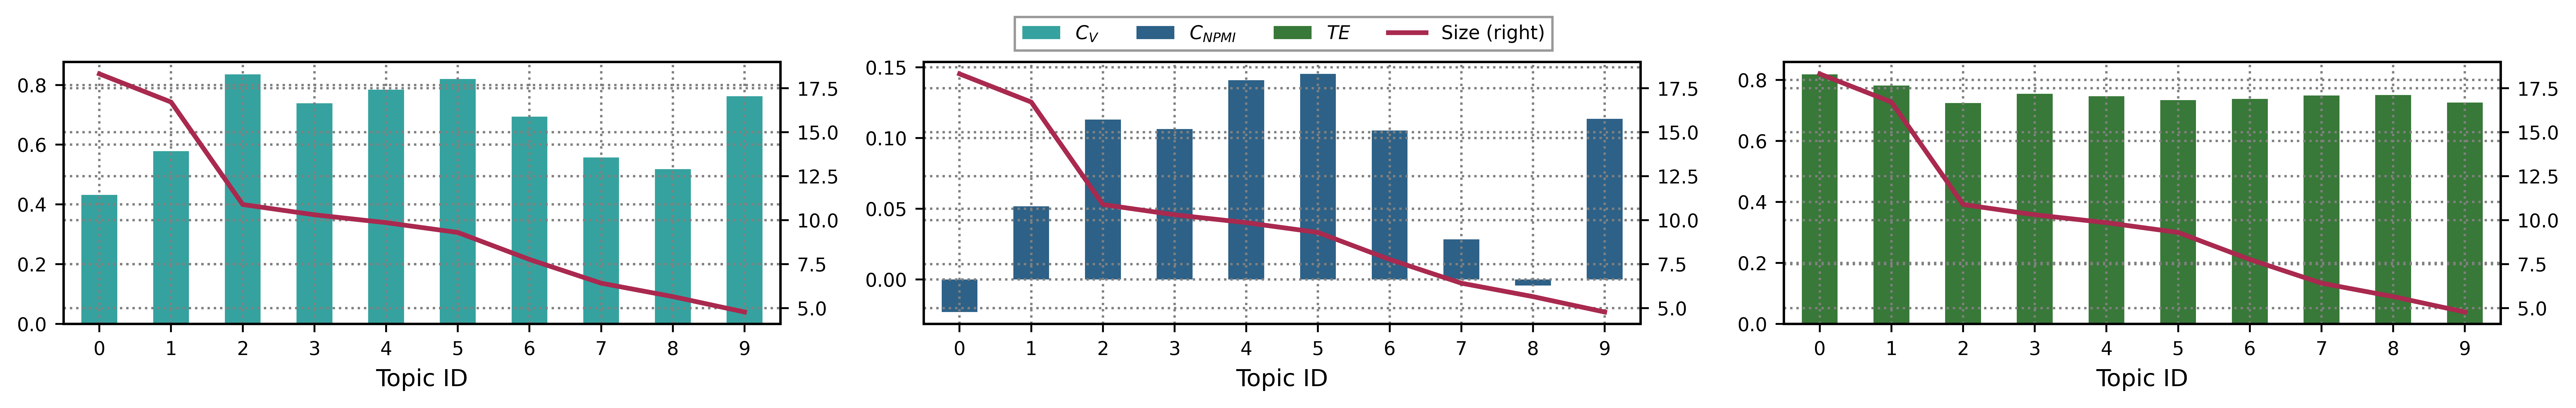

In [95]:
df10, df10_root, root_size10 = get_graphs_root_model(df,10)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df10)

#### Submodels

In [ ]:
df10_sub = get_submodules(df10_root)

##### HTM-WS

In [ ]:
df10_ws = get_ws_graphs(df10_sub, df10)

In [ ]:
tpc = 5
filtered_df = df6_ws[(df6_ws['iter'] == 0) & (df6_ws['exp_tpc'] == tpc) & (df6_ws['tr_tpcs'] == 10)].explode('tpc_descriptions')
filtered_df['id'] = np.arange(len(filtered_df))

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth', None):
    display(filtered_df[['id', 'tpc_descriptions']])

### 20 topics root model

,cohrs_cv_mean,cohrs_npmi_mean,entropies_mean,alphas_mean,tpc_ids,td,rbo,tpc_descriptions
tpc_ids,,,,,,,,
0,0.617,0.067,0.771,11.253,0,0.8,0.979,"robotic, wireless, automatic, mobile, operation, vehicle, sensor, computation, hardware, traffic, scalability, transport, road, artificial_intelligence, video"
1,0.235,-0.086,0.785,10.117,1,0.8,0.979,"transport, nuclear, health, interactive, nanotechnology, invite, website, upgrade, private, critical_mass, consultation, operation, open_access, achievement, green_deal"
2,0.293,-0.059,0.775,6.237,2,0.8,0.979,"firm, child, family, poverty, uncertainty, labour, belief, behaviour, macroeconomic, incentive, behavioural, psychological, insurance, capital, choice"
3,0.626,0.045,0.748,5.535,3,0.8,0.979,"aircraft, composite, electric, flight, mechanical, engine, noise, inspection, coating, surface, aerospace, temperature, aviation, thermal, glass"
4,0.814,0.158,0.690,5.370,4,0.8,0.979,"energy, carbon_dioxide, battery, fuel, emission, energy_efficiency, solar, electricity, renewable_energy, hydrogen, grid, electric, heat, storage, vehicle"
5,0.711,0.104,0.726,5.369,5,0.8,0.979,"catalysis, molecule, polymer, nanoparticle, metal, chemical, organic, surface, synthesis, reaction, electric, solar_cell, nanostructure, nanomaterial, membrane"
6,0.524,0.007,0.748,5.216,6,0.8,0.979,"particle, galaxy, quantum, energy, universe, star, conjecture, geometry, equation, black_hole, dark_matter, solar, dynamical, geometric, computation"
7,0.735,0.120,0.726,5.130,7,0.8,0.979,"water, food, waste, farming, agriculture, plant, crop, biomass, chemical, plastic, wastewater, bio_base, aquaculture, recycling, raw_material"
8,0.815,0.155,0.712,4.888,8,0.8,0.979,"quantum, optic, electric, photonic, laser, magnetic, atom, semiconductor, electron, spin, photon, molecule, graphene, nanoscale, chip"


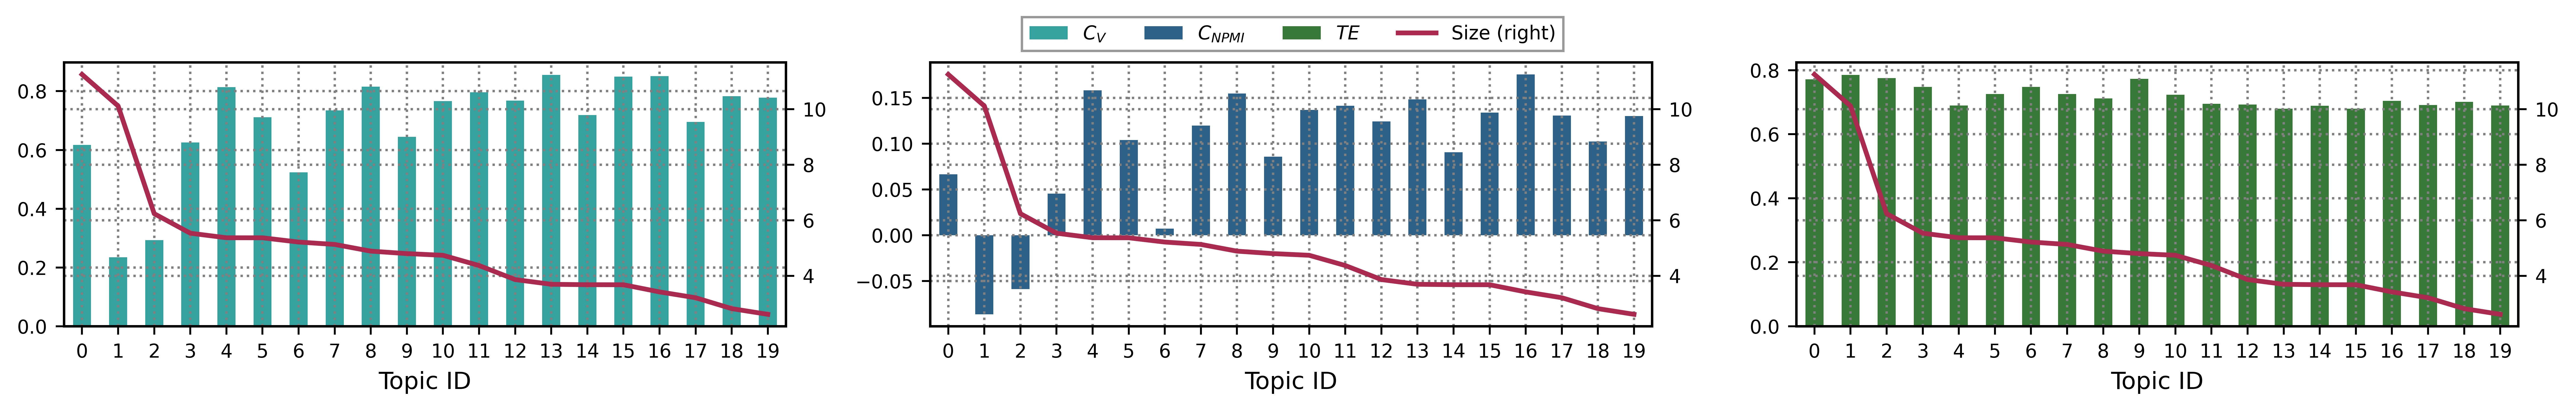

In [96]:
df20, df20_root, root_size20 = get_graphs_root_model(df,20)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df20)